In [20]:
import os
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import copy
from skimage.color import rgb2lab, lab2rgb

In [21]:
import gc
from random import sample

## Read Data

In [25]:
#path = "Datasets/0000/000000.png"
#images = np.array(Image.open(path).resize((256,512)))
#images = np.expand_dims(images,axis=0)
images = []
l = 0
for filename in os.listdir("Datasets")[16:20]:
    for file in os.listdir("Datasets/"+filename):
        path = "Datasets/"+filename+"/"+file
        images.extend(np.array(Image.open(path).resize((256,512))))
    l = l+ len(list(os.listdir("Datasets/"+filename)))
    print(l)

1000
2000
3000
4000


In [26]:
images = np.array(images).reshape(l,512,256,3)

In [27]:
images = images.astype(np.uint8)
np.save("checkpoint/16_20.npy",images)

In [9]:
#images = np.load("checkpoint/10_16.npy")

## Determine frequent colours

Defining function to show most prominent 6 colours

In [28]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

In [29]:
#Using Kmeans clustering to identify the most prominent colours
clt = KMeans(n_clusters = 6,n_init='auto', random_state= 23) 

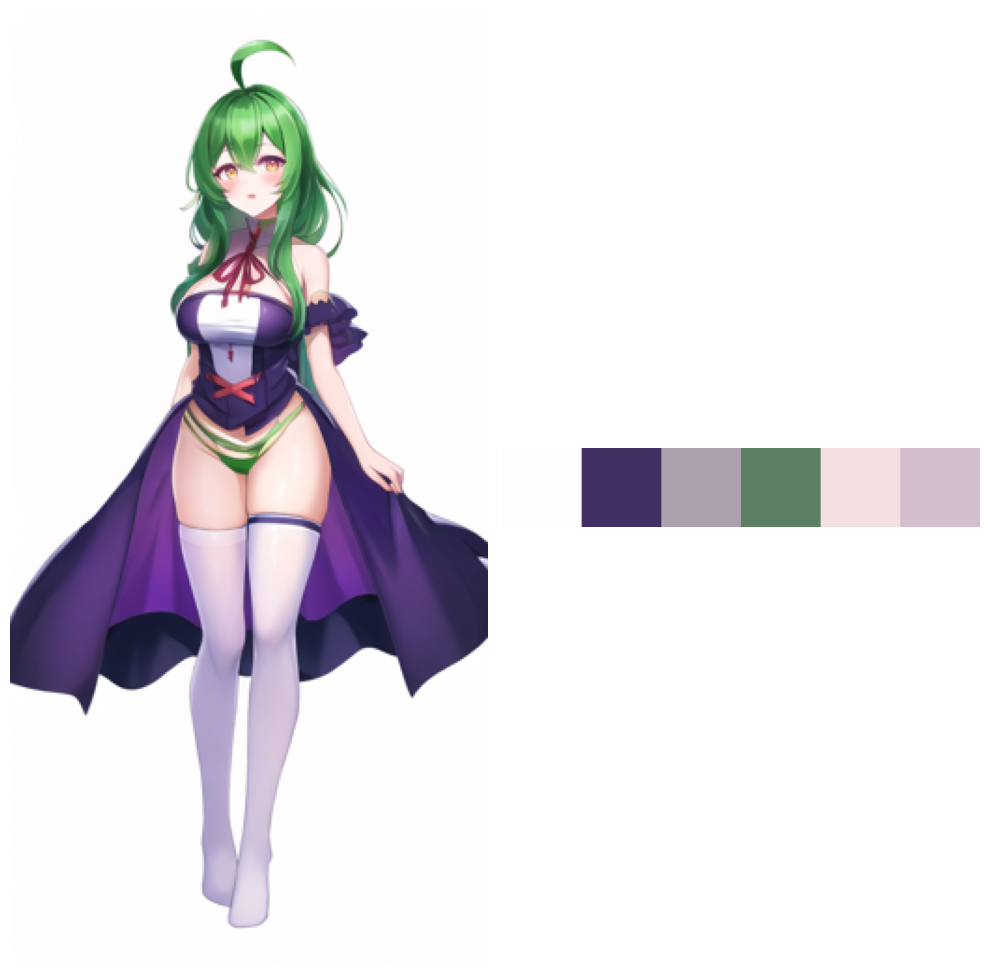

In [30]:
#Checking if the clusters work sufficiently
img = images[5,:,:,:]
clt_1 = clt.fit(img.reshape(-1, 3))
show_img_compar(img, palette(clt_1))


In [32]:
#Find dominant colors for all images 
color_clusters = []
#print(color_clusters.shape)
for i in images:
    clt = clt.fit(i.reshape(-1, 3))
    #print(color_clusters.shape)
    color_clusters.extend(clt.cluster_centers_)

In [33]:
color_clusters = np.array(color_clusters).reshape(len(images),6,3)

In [34]:
color_clusters = color_clusters.astype(np.uint8)
#np.save("checkpoint/color_clusters16_20.npy",color_clusters)

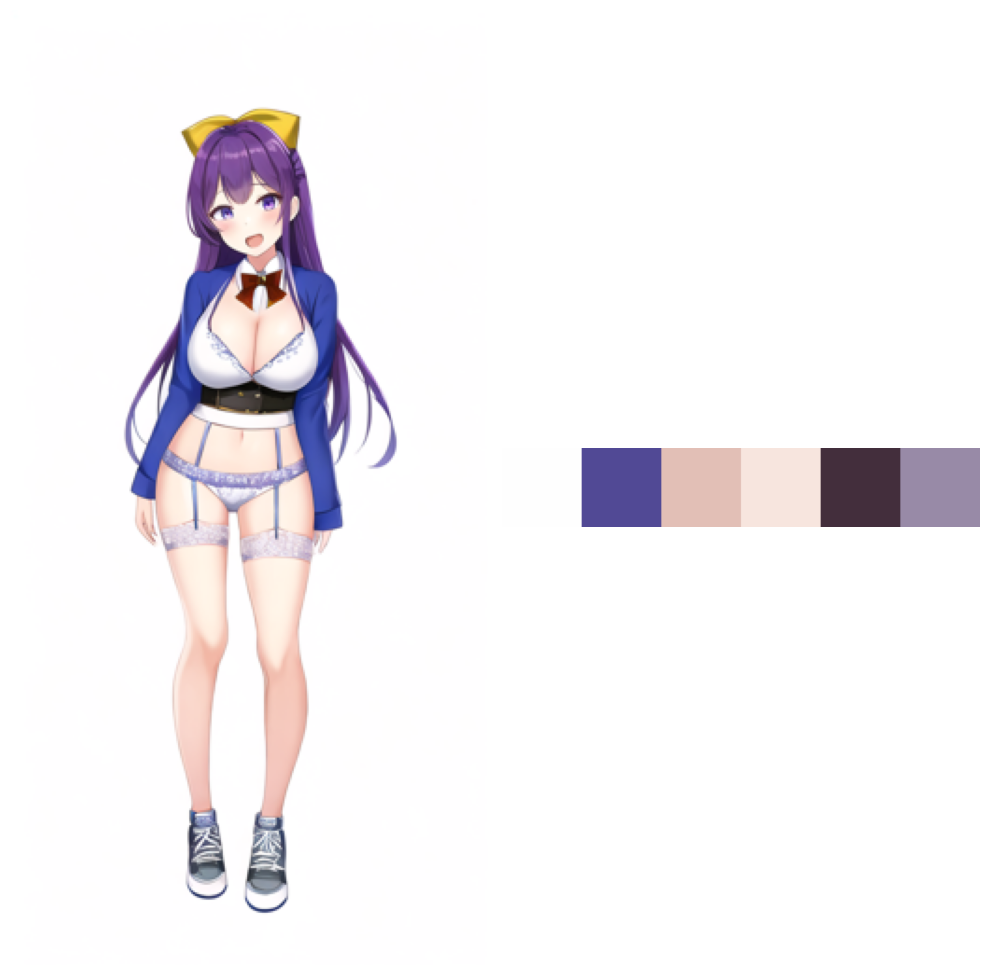

In [35]:
img_2 = images[2,:,:,:]
clt_2 = clt.fit(img_2.reshape(-1, 3))
show_img_compar(img_2, palette(clt_2))

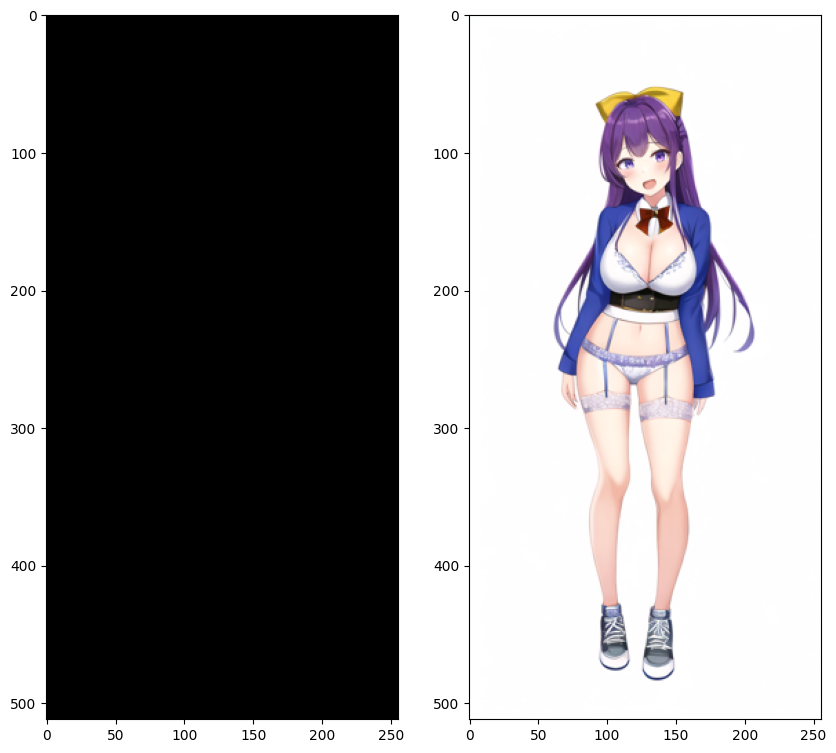

In [37]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,10))
color = color_clusters[2,2,:]
mask = cv2.inRange(img_2, color-30, color+30)
result = cv2.bitwise_and(img_2, img_2, mask=mask)
ax1.imshow(result)
ax2.imshow(img_2)
plt.show()

## Experimenting to find the right way to find coordinates

In [ ]:
window =10
mask_range = 15
img_2 = images[2,:,:,:]
color = clt_2.cluster_centers_[1]
slot = 250
x=1
for i in range(0,502,10):
    for j in range(0,240,10):
        r = np.mean(images[x,i:i+window,j:j+window,0])
        g = np.mean(images[x,i:i+window,j:j+window,1])
        b = np.mean(images[x,i:i+window,j:j+window,2])
        #print(r,g,b)
        diff = abs(color[0] - r) + abs(color[1]-g) + abs(color[2]-b)
        if(diff < slot):
            slot = diff
            slot_coord = [i,j]
            #print(diff)
            #print(slot_coord)
        if diff < 50:
            break
    

In [ ]:
print(slot_coord)
print(slot)

[220, 140]
58.87129145095843


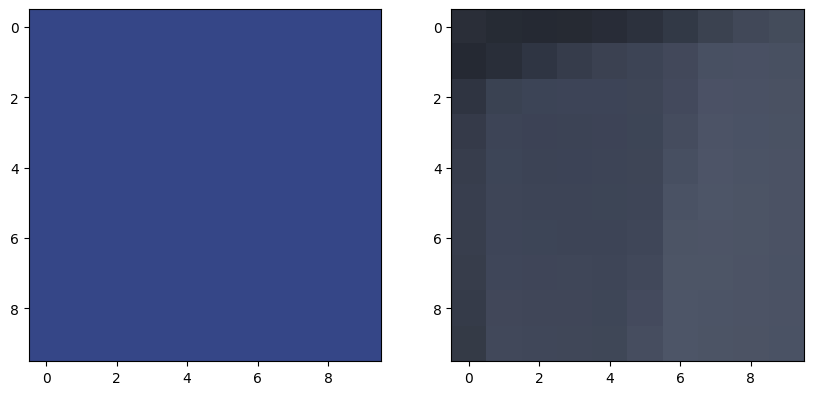

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(np.broadcast_to(color.astype(int),(10,10,3)))
ax2.imshow(images[1,220:230,140:150,:])
#plt.show()

## looping it to get co-ords for all colours and all images

In [38]:
window =10
mask_range = 15
slot_coord = np.ones((1,2),dtype = int)
slot_coord_image = []
color_coords = []
for a in range(0,len(images)):
    slot_coord_image=[]
    for b in range(0,6):
        color = color_clusters[a,b,:]
        slot = 250
        for i in range(0,502,10):
            flag = False
            for j in range(0,240,10):
                r = np.mean(images[a,i:i+window,j:j+window,0])
                g = np.mean(images[a,i:i+window,j:j+window,1])
                b = np.mean(images[a,i:i+window,j:j+window,2])
                #print(r,g,b)
                diff = abs(color[0] - r) + abs(color[1]-g) + abs(color[2]-b)
                if diff < slot:
                    slot = diff
                    slot_coord = [i,j]
                    #print(diff)
                    #print(slot_coord)
                if diff < 30:
                    flag = True
                    #print(i)
                    break
            if flag:
                break
        
        slot_coord_image.extend(slot_coord)
        #print(slot_coord_image)
    slot_coord_image = np.array(slot_coord_image).reshape((6,2))
    color_coords.extend(slot_coord_image)

color_coords = np.array(color_coords).reshape((len(images),6,2))

In [39]:
color_coords = color_coords.astype(np.uint16)
#np.save("checkpoint/color_coords16_20.npy",color_coords)

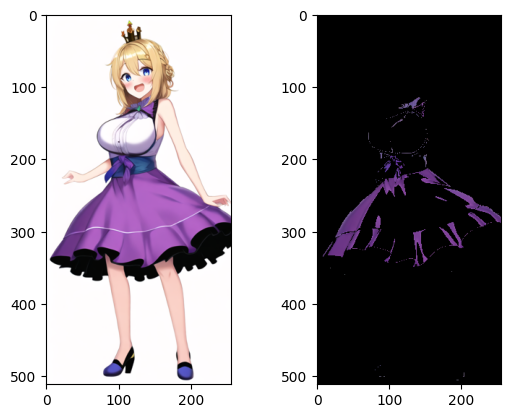

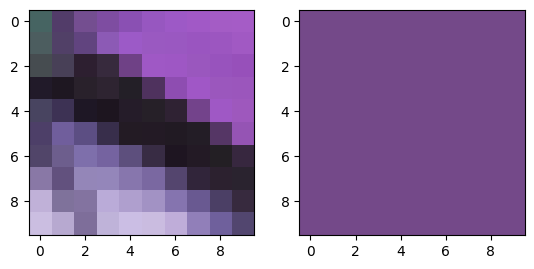

In [40]:
#Check the masks for each colour, colours in picked co-ords and original colours
image_idx = 6
cluster_idx = 4
color = color_clusters[image_idx,cluster_idx,:]
x = color_coords[image_idx,cluster_idx,0]
y = color_coords[image_idx,cluster_idx,1]
fig, (ax1,ax2) = plt.subplots(1, 2)
img = images[image_idx,:,:,:]
ax1.imshow(img)
mask = cv2.inRange(img, color-30, color+30)
result = cv2.bitwise_and(img, img, mask=mask)
ax2.imshow(result)
fig, (ax3,ax4) = plt.subplots(1, 2)
ax3.imshow(images[image_idx,x:x+10,y:y+10,:])
ax4.imshow(np.broadcast_to(color.astype(int),(10,10,3)))
#plt.show()

In [ ]:
#del images_load, images_lab
#gc.collect()

NameError: name 'images_load' is not defined

In [41]:
# adding an image with small color sqaures (10*10) for each of 6 clusters
# user inputs will result in similar pictures with color squares
blot_layer = []
for image_idx in range(0,len(images)):
    layer = np.zeros((512,256,3),dtype=int)
    for cluster_idx in range(0,6):
        blot = np.zeros((512,256,3),dtype=int)
        x = color_coords[image_idx,cluster_idx,0]
        y = color_coords[image_idx,cluster_idx,1]
        blot[x:x+10,y:y+10,0] = color_clusters[image_idx,cluster_idx,0]
        blot[x:x+10,y:y+10,1] = color_clusters[image_idx,cluster_idx,1]
        blot[x:x+10,y:y+10,2] = color_clusters[image_idx,cluster_idx,2]
        layer = layer + blot
    blot_layer.extend(layer)



In [42]:
blot_layer = np.array(blot_layer).astype(np.uint8)
blot_layer = np.array(blot_layer).reshape((len(images),512,256,3))

[[  0   0]
 [ 10 100]
 [ 60 100]
 [ 20 130]
 [ 40 160]
 [ 10 150]]


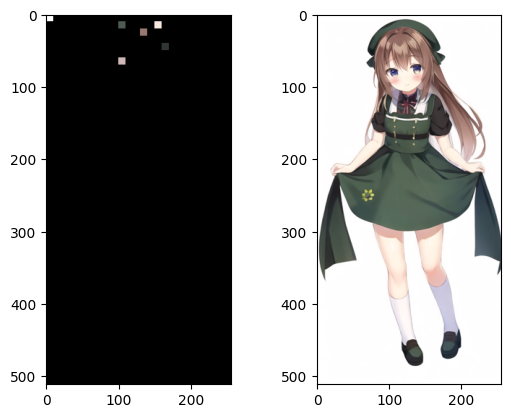

In [43]:
image_idx = 69
print(color_coords[image_idx,:,:])
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.imshow(blot_layer[image_idx,:,:,:])
ax2.imshow(images[image_idx,:,:,:])

In [44]:
# computationally much easier to generate blot layers than to
# store them and shift them between databases
# blot_layers are not that useful so skipping their storage to save resources
#np.save("checkpoint/color_blots16_20.npy",blot_layer)

In [45]:
del blot_layer, color_clusters, color_coords
gc.collect()

22767

## LAB Images

Splitting the length into half to fit it in RAM

In [46]:
images_lab1 = []
for image_idx in range(0,int(len(images)/2)):
    
    images_lab1.extend(rgb2lab(images[image_idx,:,:,:]))

images_lab1 = np.array(images_lab1).reshape((int(len(images)/2),512,256,3))

In [47]:
images_lab2 = []
for image_idx in range(int(len(images)/2), len(images)):
    
    images_lab2.extend(rgb2lab(images[image_idx,:,:,:]))

images_lab2 = np.array(images_lab2).reshape((int(len(images)/2),512,256,3))

Concatenating both to create the final set

In [48]:
gc.collect()
images_lab2 = images_lab2.astype(np.float16)
images_lab1 = images_lab1.astype(np.float16)

In [49]:
images_lab = np.concatenate([images_lab1,images_lab2],axis=0)
del images_lab1, images_lab2
gc.collect()

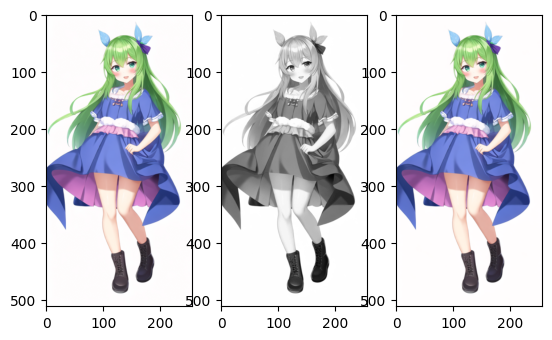

In [ ]:
image_idx = 42
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4)
img = lab2rgb(images_lab[image_idx,:,:,:])
ax1.imshow(img)
gray_img_rgb = lab2rgb(images_lab[image_idx,:,:,])
ax2.imshow(images_lab[image_idx,:,:,0],cmap = "gray")
ax3.imshow(blot_layer[image_idx,:,:,:])
ax4.imshow(images[image_idx,:,:,:])

In [52]:
images_lab = images_lab.astype(np.float16)
#print(images_lab[42,300,100,:])

In [53]:
np.save("checkpoint/1001_LAB16_20.npy",images_lab)

## test saved files

In [23]:
images_load = np.load("checkpoint/1001_LAB1_3.npy")

In [24]:
color_blots = np.load("checkpoint/color_blots1_3.npy")

In [25]:
print(images_load[42,300,100,:])

[40.   38.94 -4.06]


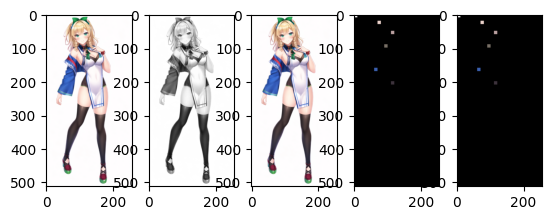

In [27]:
image_idx = 55
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5)
img = lab2rgb(images_lab[image_idx,:,:,:])
ax1.imshow(img)
#gray_img_rgb = lab2rgb(images_lab[image_idx,:,:,])
ax2.imshow(images_lab[image_idx,:,:,0],cmap = "gray")
ax3.imshow(lab2rgb(images_load[image_idx,:,:,:]))
ax4.imshow(blot_layer[image_idx,:,:,:])
ax5.imshow(color_blots[image_idx,:,:,:])